dataset
https://www.kaggle.com/c/data-science-bowl-2018

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
""" 사용가능한 GPU가 있으시면 바꿔주세요. """
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

In [ ]:
# Set hyper-parameters
""" Computation cost -> 128x128 resize """
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
width_out = 128
height_out = 128

In [ ]:
!ls

dataset      __MACOSX	RPA_ResUNet.py	 UNet-iou.py  UNet.pdf
dataset.zip  module.py	unet-iou-cvc.pt  Unet.ipynb


In [ ]:
%cd /content/drive/MyDrive/dacon_dacrew/unet

/content/drive/MyDrive/dacon_dacrew/unet


In [ ]:
# !unzip dataset.zip

In [ ]:
rt_path = "dataset/"
TRAIN_PATH = os.path.join(rt_path, "stage1_train/")
TEST_PATH = os.path.join(rt_path, "stage1_test/")

train_dir = os.listdir(TRAIN_PATH)
test_dir = os.listdir(TEST_PATH)
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

x_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), height_out, width_out, 1), dtype=bool)
x_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i, id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = cv2.imread(path+'/images/'+id_+'.png')
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    x_train[i] = img

    mask = np.zeros((height_out, width_out, 1), dtype=bool)
    mask_path = path+'/masks/'
    for id_ in os.listdir(mask_path):
        mask_ = cv2.imread(mask_path+id_, 0)
        mask_ = cv2.resize(mask_, (height_out, width_out))
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)
    y_train[i] = mask

In [ ]:
""" augmentation custom dataset """
class ResUNetDataset(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))

        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')

        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.center_crop(image, (128, 128))
        mask = TF.center_crop(mask, (128, 128))

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask

    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)
train_dataset = ResUNetDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

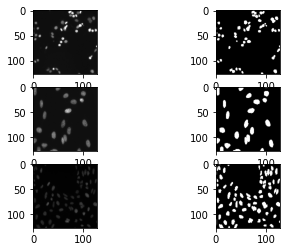

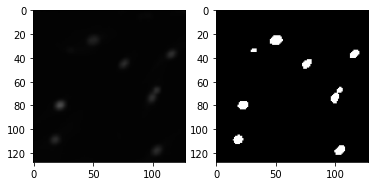

In [ ]:
" Visualize images "
fig, ax = plt.subplots(nrows=3, ncols=2)
ax[0][0].imshow(x_train[0])
ax[0][1].imshow(np.squeeze(y_train[0]), cmap='gray')
ax[1][0].imshow(x_train[1])
ax[1][1].imshow(np.squeeze(y_train[1]), cmap='gray')
ax[2][0].imshow(x_train[2])
ax[2][1].imshow(np.squeeze(y_train[2]), cmap='gray')

" Visualize augmentation "
for aug_img, aug_mask in train_loader:
    img = np.array(TF.to_pil_image(aug_img[0]))
    mask = np.array(TF.to_pil_image(aug_mask[0]))

    fig, (axis_1, axis_2) = plt.subplots(1, 2)
    axis_1.imshow(img.astype(np.uint8))
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    plt.show()

    break

In [ ]:
""" Evaluation metric: Intersection Over Union;
    일반적으로 segmentation 관점에서 IoU, Jaccard coef, Dice coef, P&R를 
    사용하실 수 있고 baseline 모델이라 IoU만 계산하였습니다. """
    
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):
      pred_inds = pred == cls
      target_inds = target == cls
      intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()
      union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
    
      if union == 0:
        iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
      else:
        iou.append(float(intersection) / float(max(union, 1)))
     
    return sum(iou)

def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

""" UNet definition """
class UNet(nn.Module):
    def cont_block(self, in_channels, out_channels, kernel_size=3):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.Dropout2d(), # p=0.5
                              nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_channels))
        return block
    
    def expn_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=mid_channel,
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.Dropout2d(),
                              nn.Conv2d(in_channels=mid_channel, out_channels=mid_channel,
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(mid_channel),
                              nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels,
                                                 kernel_size=kernel_size, stride=2, padding=1, output_padding=1))
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=mid_channel,
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.Dropout2d(),
                              nn.Conv2d(in_channels=mid_channel, out_channels=mid_channel,
                                        kernel_size=kernel_size, padding=1),
                              nn.ReLU(),
                              nn.BatchNorm2d(mid_channel),
                              nn.Conv2d(in_channels=mid_channel, out_channels=out_channels,
                                        kernel_size=kernel_size, padding=1),
                              nn.Sigmoid()
                              )
        return block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        self.contl_1 = self.cont_block(in_channels=in_channel, out_channels=64)
        self.contl_1_mp = nn.MaxPool2d(kernel_size=2)
        self.contl_2 = self.cont_block(in_channels=64, out_channels=128)
        self.contl_2_mp = nn.MaxPool2d(kernel_size=2)
        self.contl_3 = self.cont_block(in_channels=128, out_channels=256)
        self.contl_3_mp = nn.MaxPool2d(kernel_size=2)
        self.contl_4 = self.cont_block(in_channels=256, out_channels=512)
        self.contl_4_mp = nn.MaxPool2d(kernel_size=2)
        
        self.bottleneck = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, 
                                                  kernel_size=3, padding=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(1024),
                                        nn.Conv2d(in_channels=1024, out_channels=1024, 
                                                  kernel_size=3, padding=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(1024),
                                        nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                                           kernel_size=3, stride=2, padding=1, output_padding=1)
                                        )
        
        self.expnl_1 = self.expn_block(1024, 512, 256)
        self.expnl_2 = self.expn_block(512, 256, 128)
        self.expnl_3 = self.expn_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
    
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        contl_1_out = self.contl_1(x)
        contl_1_pool = self.contl_1_mp(contl_1_out)
        contl_2_out = self.contl_2(contl_1_pool)
        contl_2_pool = self.contl_2_mp(contl_2_out)
        contl_3_out = self.contl_3(contl_2_pool)
        contl_3_pool = self.contl_3_mp(contl_3_out)
        contl_4_out = self.contl_4(contl_3_pool)
        contl_4_pool = self.contl_4_mp(contl_4_out)
        
        bottleneck_out = self.bottleneck(contl_4_pool)
        
        """ Skip connection of the expansive sub-module """
        expnl_1_cat = self.crop_and_concat(bottleneck_out, contl_4_out)
        expnl_1_out = self.expnl_1(expnl_1_cat)
        expnl_2_cat = self.crop_and_concat(expnl_1_out, contl_3_out)
        expnl_2_out = self.expnl_2(expnl_2_cat)
        expnl_3_cat = self.crop_and_concat(expnl_2_out, contl_2_out)
        expnl_3_out = self.expnl_3(expnl_3_cat)
        final_cat = self.crop_and_concat(expnl_3_out, contl_1_out)
        final_out = self.final_layer(final_cat)
        
        return final_out

In [ ]:
model = UNet(in_channel=3, out_channel=1).to(device)
# print(model)

epochs=25 # 3 -> 25
alpha=5
batch_size = 16 # 각자 메모리 상태에 맞게 변경하셔도 됩니다.
# nn.CrossEntropyLoss() (paper) -> BCELoss()
criterion=nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_iou_sum = 0
valid_iou_sum = 0

train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(image.float())
    
        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader:
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training IoU: ", train_iou/len(train_loader), "Validation IoU: ", valid_iou/len(valid_loader))
    train_iou_sum += train_iou/len(train_loader)
    valid_iou_sum += valid_iou/len(valid_loader)

    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader)
)
    
print("Training Mean IoU: {:.2f}".format(train_iou_sum/epochs), " Validation Mean IoU: {:.2f}".format(valid_iou_sum/epochs))
    
PATH = 'unet-iou-cvc.pt'
torch.save(model.state_dict(), PATH)

Epoch  1  Training Loss:  tensor(0.6352, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.5665, device='cuda:0')
Training IoU:  0.1709133768972289 Validation IoU:  0.06423940657259013
Epoch  2  Training Loss:  tensor(0.5315, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.4069, device='cuda:0')
Training IoU:  0.332834567995027 Validation IoU:  0.19424784546867563
Epoch  3  Training Loss:  tensor(0.4365, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3231, device='cuda:0')
Training IoU:  0.40403752780321023 Validation IoU:  0.24000824888199468
Epoch  4  Training Loss:  tensor(0.3597, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3404, device='cuda:0')
Training IoU:  0.3875078836220584 Validation IoU:  0.24124377260529137
Epoch  5  Training Loss:  tensor(0.2881, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.2558, device='cuda:0')
Training IoU:  0.37317700037899737 Validation IoU:  0.18

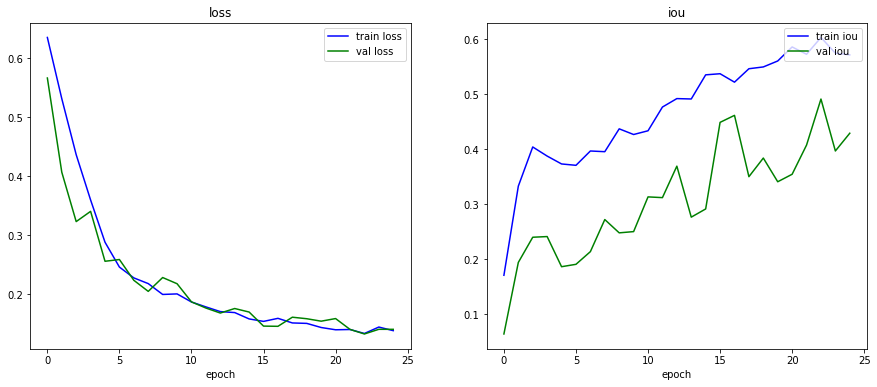

In [ ]:
train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

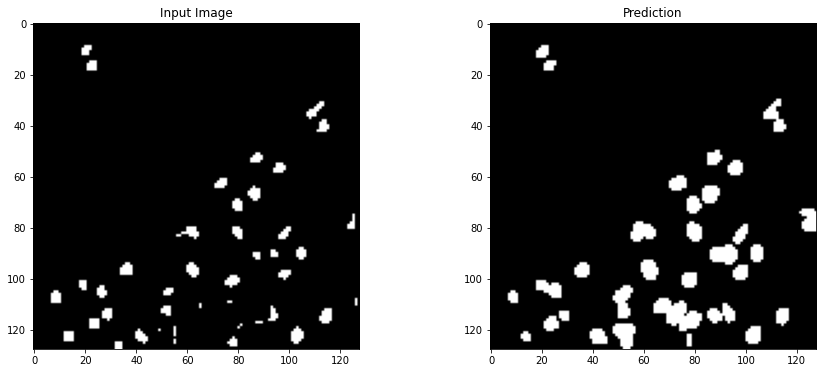

In [ ]:
""" prediction / ground truth visualization """
for img_, mask_ in test_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_1.set_title('Input Image')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    axis_2.set_title('Prediction')
    plt.show()

    break